In [1]:
import numpy
import datasets
import requests
from datasets import load_dataset
import numpy as np
from huggingface_hub import hf_hub_download
import openai 
from tqdm import tqdm
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt

In [3]:
# dataset_orig = load_dataset('relbert/t_rex')
ood_idxs_file = "trex_ood_idxs_128+.npy"
ood_idxs = np.load(ood_idxs_file)

trex_num_mentions = np.load("trex_num_mentions.npy")
# ood_dataset = dataset_orig["train"].select(ood_idxs)

In [4]:
trex_num_mentions[ood_idxs]

array([  307,   182,   355, ...,  1184, 92775,   433])

(array([5788.,  480.,  145.,   61.,   49.,   36.,   15.,   16.,   14.,
          13.]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <BarContainer object of 10 artists>)

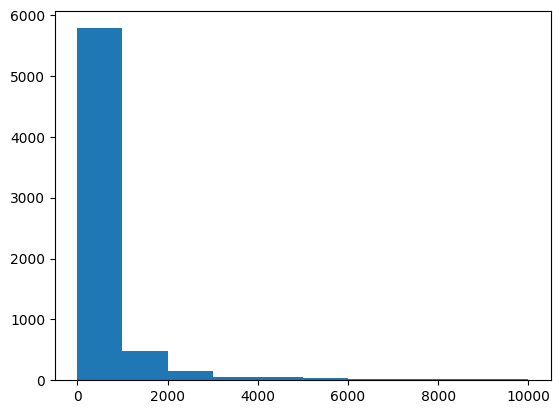

In [6]:
plt.hist(trex_num_mentions[ood_idxs], range=(0, 10000))

In [7]:
trex_num_mentions[ood_idxs].mean()

838.5602274427653

In [9]:
np.median(trex_num_mentions[ood_idxs])

283.0

In [15]:
ppo_model_path = "ckpts/ppo_lama_GPT2_3_commit30_hedge25.5_6.5_idk11_cr0.0005/checkpoint_80000/hf_model"
ppo_generation_categories = np.load(ppo_model_path+"/generation_categories_trex_ood_idxs_128+.npy")


In [5]:
def get_stats(generation_categories, idxs):

    num_commit_correct = len(np.where(generation_categories[idxs, 1]==1)[0])
    num_commit_wrong = len(np.where(generation_categories[idxs, 2]==1)[0])
    num_dont_know = len(np.where(generation_categories[idxs, 3]==1)[0])
    num_wrong = len(np.where(generation_categories[idxs, 4]==1)[0])
    num_hedge_correct = len(np.where(generation_categories[idxs, 5]==1)[0])
    num_hedge_wrong = len(np.where(generation_categories[idxs, 6]==1)[0])
    num_total = len(idxs)
    reward = (30*num_commit_correct+25.5*num_hedge_correct+6.5*num_hedge_wrong+11*(num_dont_know))/num_total
    print("frac commit: ", (num_commit_correct+num_commit_wrong)/num_total)
    a = (num_commit_correct+num_commit_wrong)/num_total
    print("frac hedge: ", (num_hedge_correct+num_hedge_wrong)/num_total)
    b = (num_hedge_correct+num_hedge_wrong)/num_total
    print("frac dont know: ", num_dont_know/num_total)
    c = num_dont_know/num_total
    print("frac commit correct: ", num_commit_correct/(num_commit_correct+num_commit_wrong))
    d = num_commit_correct/(num_commit_correct+num_commit_wrong)
    print("frac hedge correct: ", num_hedge_correct/(num_hedge_correct+num_hedge_wrong))
    e = num_hedge_correct/(num_hedge_correct+num_hedge_wrong)
    print("reward: ", reward)
    return a, b, c, d,e,reward

In [17]:
get_stats(ppo_generation_categories, [_ for _ in range(len(ppo_generation_categories))])

frac commit:  0.35403262008080205
frac hedge:  0.44500972617088136
frac dont know:  0.18883734849618436
frac commit correct:  0.06043956043956044
frac hedge correct:  0.03597848016139879
reward:  5.915906030225947


(0.35403262008080205,
 0.44500972617088136,
 0.18883734849618436,
 0.06043956043956044,
 0.03597848016139879,
 5.915906030225947)

In [4]:
sft_model_path =  "ckpts/sft_lama_GPT2_commit/checkpoint_10000/hf_model"
sft_log_liks = np.load(sft_model_path+"/generated_answer_log_probs_mean_trex_ood_idxs_128+.npy")
sft_generation_categories = np.load(sft_model_path+"/generation_categories_trex_ood_idxs_128+.npy")

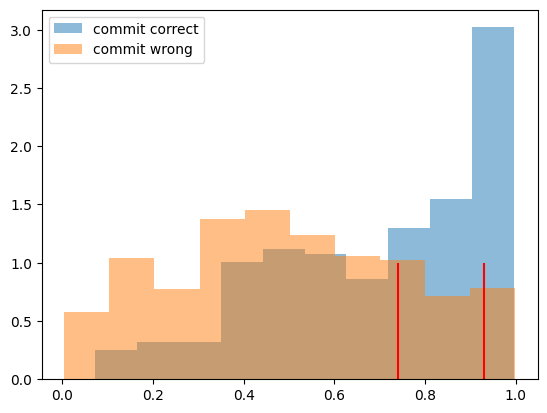

In [5]:
plt.hist(np.e**np.array(sft_log_liks)[np.where(sft_generation_categories[:, 1]==1)[0]], density=True, alpha=0.5, label="commit correct")

plt.hist(np.e**np.array(sft_log_liks)[np.where(sft_generation_categories[:, 2]==1)[0]], density=True, alpha=0.5, label="commit wrong")

plt.legend()

best_threshold1 = .74
best_threshold2 = .93

plt.vlines(best_threshold1, 0, 1, color="red")
plt.vlines(best_threshold2, 0, 1, color="red")

In [11]:
correct_sft_generated_answer_probs_means = np.e**np.array(sft_log_liks)[np.where(sft_generation_categories[:, 1]==1)[0]]
wrong_sft_generated_answer_probs_means = np.e**np.array(sft_log_liks)[np.where(sft_generation_categories[:, 2]==1)[0]]

best_threshold1 = .74
best_threshold2 = .93

commit_correct = (np.where(correct_sft_generated_answer_probs_means>best_threshold2)[0].shape[0])
commit_wrong = (np.where(wrong_sft_generated_answer_probs_means>best_threshold2)[0].shape[0])

hedge_correct = (np.where(np.logical_and(correct_sft_generated_answer_probs_means>best_threshold1, correct_sft_generated_answer_probs_means<best_threshold2))[0].shape[0])
hedge_wrong = (np.where(np.logical_and(wrong_sft_generated_answer_probs_means>best_threshold1, wrong_sft_generated_answer_probs_means<best_threshold2))[0].shape[0])

dont_know_correct = (np.where(correct_sft_generated_answer_probs_means<best_threshold1)[0].shape[0])
dont_know_wrong = (np.where(wrong_sft_generated_answer_probs_means<best_threshold1)[0].shape[0])

total = commit_correct+commit_wrong+hedge_correct+hedge_wrong+dont_know_correct+dont_know_wrong

commmit_correct_percentage = commit_correct/(commit_correct+commit_wrong)
hedge_correct_percentage = hedge_correct/(hedge_correct+hedge_wrong)
dont_know_correct_percentage = dont_know_correct/(dont_know_correct+dont_know_wrong)

reward = (30*commit_correct+25.5*hedge_correct+6.5*hedge_wrong+11*(dont_know_correct+dont_know_wrong))/total

print("frac commit: ", (commit_correct+commit_wrong)/total)
print("frac hedge: ", (hedge_correct+hedge_wrong)/total)
print("frac dont know: ", (dont_know_correct+dont_know_wrong)/total)
print("frac commit correct: ", commmit_correct_percentage)
print("frac hedge correct: ", hedge_correct_percentage)
print("reward: ", reward)


frac commit:  0.06937577255871447
frac hedge:  0.15173053152039556
frac dont know:  0.77889369592089
frac commit correct:  0.16258351893095768
frac hedge correct:  0.0835030549898167
reward:  10.1331891223733


In [13]:
correct_frac = np.where(sft_generation_categories[:, 1]==1)[0].shape[0]/len(sft_generation_categories)

In [14]:
print("all commit reward: ", 30*correct_frac)
print("all hedge reward: ", 25.5*correct_frac+6.5*(1-correct_frac))
print("all idk reward: ", 11)

all commit reward:  1.351189585515487
all hedge reward:  7.355753404159809
all idk reward:  11


In [15]:
dataset_orig = load_dataset('lama')
ood_idxs = np.load("lama_ood_idxs2.npy")
train_idxs = np.load("lama_train_idxs2.npy")
test_idxs = np.load("lama_test_idxs2.npy")

dataset = dataset_orig["train"].select(train_idxs)
test_dataset = dataset_orig["train"].select(test_idxs)
ood_dataset = dataset_orig["train"].select(ood_idxs)

In [20]:
set(dataset["template"]).intersection(set(ood_dataset["template"]))

set()

In [16]:
def get_stats(generation_categories, idxs):

    num_commit_correct = len(np.where(generation_categories[idxs, 1]==1)[0])
    num_commit_wrong = len(np.where(generation_categories[idxs, 2]==1)[0])
    num_dont_know = len(np.where(generation_categories[idxs, 3]==1)[0])
    num_wrong = len(np.where(generation_categories[idxs, 4]==1)[0])
    num_hedge_correct = len(np.where(generation_categories[idxs, 5]==1)[0])
    num_hedge_wrong = len(np.where(generation_categories[idxs, 6]==1)[0])
    num_total = len(idxs)
    reward = (14*num_commit_correct+10*(num_dont_know))/num_total
    print("frac commit: ", (num_commit_correct+num_commit_wrong)/num_total)
    a = (num_commit_correct+num_commit_wrong)/num_total
    print("frac dont know: ", num_dont_know/num_total)
    c = num_dont_know/num_total
    print("frac commit correct: ", num_commit_correct/(num_commit_correct+num_commit_wrong))
    d = num_commit_correct/(num_commit_correct+num_commit_wrong)
    print("reward: ", reward)
    return a, c, d,reward

In [17]:
ppo_model_path =  "ckpts/ppo_lama_llama7B_3_commit14_lr5e-5/checkpoint_30000/hf_model"
ppo_generation_categories = np.load(ppo_model_path+"/generation_categories_trex_ood_idxs_128+.npy")

In [19]:
get_stats(ppo_generation_categories, [_ for _ in range(len(ppo_generation_categories))])

frac commit:  0.7222804129881789
frac dont know:  0.2759239862337274
frac commit correct:  0.29687176299979284
reward:  5.761185096513541


(0.7222804129881789,
 0.2759239862337274,
 0.29687176299979284,
 5.761185096513541)

In [20]:

ppo_model_path =  "ckpts/sft_lama_llama7B_2_commit_lr1e-5/checkpoint_3000/hf_model"
ppo_generation_categories = np.load(ppo_model_path+"/generation_categories_trex_ood_idxs_128+.npy")
get_stats(ppo_generation_categories, [_ for _ in range(len(ppo_generation_categories))])

frac commit:  0.999700733203651
frac dont know:  0.0
frac commit correct:  0.14563688070648106
reward:  2.038306149932665


(0.999700733203651, 0.0, 0.14563688070648106, 2.038306149932665)

In [21]:
ppo_model_path =  "ckpts/sft_lama_llama7B_2_commit_lr1e-5/checkpoint_3000/hf_model"
ppo_generation_categories = np.load(ppo_model_path+"/generation_categories.npy")
get_stats(ppo_generation_categories, [_ for _ in range(len(ppo_generation_categories))])

frac commit:  0.9990173599737963
frac dont know:  0.0
frac commit correct:  0.739344262295082
reward:  10.340648542417295


(0.9990173599737963, 0.0, 0.739344262295082, 10.340648542417295)

In [23]:
ppo_model_path =  "ckpts/ppo_lama_llama7B_3_commit14_lr5e-5/checkpoint_30000/hf_model"
ppo_generation_categories = np.load(ppo_model_path+"/generation_categories.npy")
get_stats(ppo_generation_categories, [_ for _ in range(len(ppo_generation_categories))])

frac commit:  0.8643956763838847
frac dont know:  0.1349492302653128
frac commit correct:  0.8529746115953013
reward:  11.671798231247953


(0.8643956763838847,
 0.1349492302653128,
 0.8529746115953013,
 11.671798231247953)